## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, stats


## Loading Dataset

In [2]:
df = pd.read_csv("combined_cleaned_data_updated.csv")
df.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,2008-08-05 23:31:02+00:00,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1.0,1.0
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,2008-08-05 23:31:03+00:00,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1.0,1.0
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,2008-08-06 08:28:00+00:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1.0,1.0
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,2008-08-05 23:31:20+00:00,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0.0,1.0
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,2008-08-05 23:31:21+00:00,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1.0,1.0


In [3]:
df.shape

(158375, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158375 entries, 0 to 158374
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   sender    158375 non-null  object 
 1   receiver  158375 non-null  object 
 2   date      158375 non-null  object 
 3   subject   158375 non-null  object 
 4   body      158375 non-null  object 
 5   label     158375 non-null  float64
 6   urls      158375 non-null  float64
dtypes: float64(2), object(5)
memory usage: 8.5+ MB


In [5]:
df.isnull().sum()

sender      0
receiver    0
date        0
subject     0
body        0
label       0
urls        0
dtype: int64

Dataset Description: We have 158375 entries and 6 features

## Exploratory Data Analysis

### EDA for Sender

Firstly, we look at the Sender column, and determine if we can extract features from the sender. The sender follows this format (DisplayName \<locapart@domain.topLevelDomain>)
There are 4 parts to sender:

e.g Young Esposito \<Young@iworld.de>
1. Extract Domain (e.g iworld.de)
2. Extract Top Level Domain (e.g de)
3. Extract DisplayName (e.g Young Esposito)
4. Extract LocalPart (e.g Young)

In [6]:
def extract_domain(sender):
    match = re.search(r'@([a-zA-Z0-9.-]+)', sender)
    return match.group(1) if match else 'unknown'

# Extract sender domain
df['sender_domain'] = df['sender'].apply(extract_domain)

# Get domain frequency
domain_counts = df['sender_domain'].value_counts()

# Extract Top-Level Domain (TLD) Distribution
def extract_tld(domain):
    return domain.split('.')[-1] if '.' in domain else 'unknown'

df['sender_tld'] = df['sender_domain'].apply(extract_tld)
tld_counts = df['sender_tld'].value_counts()

# Suspicious Patterns
# IP-based domains (domains that are IP addresses)
def is_ip_domain(domain):
    return int(bool(re.match(r'^\d+\.\d+\.\d+\.\d+$', domain)))

df['is_ip_domain'] = df['sender_domain'].apply(is_ip_domain)

# Numeric Domains (domains with numbers)
df['has_numbers_in_domain'] = df['sender_domain'].apply(lambda x: int(any(char.isdigit() for char in x)))

# Hyphenated domains
df['has_hyphen_in_domain'] = df['sender_domain'].apply(lambda x: int('-' in x))

# Domain Length
df['domain_length'] = df['sender_domain'].apply(len)

# Cross-referencing domain with known safe and suspicious domains
known_safe_domains = ['gmail.com', 'yahoo.com', 'outlook.com']
df['is_safe_domain'] = df['sender_domain'].apply(lambda x: int(x in known_safe_domains))

# Display the EDA results
print("Domain Frequency:")
print(domain_counts)
print("\nTLD Distribution:")
print(tld_counts)
print("\nProcessed DataFrame:")
print(df)

Domain Frequency:
sender_domain
ENRON.com                   18772
gmail.com                    6070
samba.org                    3426
enron.com                    2892
yahoo.com                    2447
                            ...  
hkmail.net                      1
migue.org                       1
ejiajia.com                     1
prairiecandle.com               1
vision-of-escaflowne.com        1
Name: count, Length: 46706, dtype: int64

TLD Distribution:
sender_tld
com                  93577
net                  13759
org                  12432
edu                   6959
de                    4235
                     ...  
xy                       1
compersonaloffice        1
INC                      1
com17                    1
pg                       1
Name: count, Length: 301, dtype: int64

Processed DataFrame:
                                                   sender  \
0                        Young Esposito <Young@iworld.de>   
1                            Mok <ipline's1

In [7]:
# Get unique domains
unique_domains = df['sender_domain'].unique()
num_unique_domains = len(unique_domains)

# Get frequency of each domain
domain_counts = df['sender_domain'].value_counts()

# Create a DataFrame for all domain counts
domain_freq_df = pd.DataFrame(domain_counts).reset_index()
domain_freq_df.columns = ['sender_domain', 'count']  # Rename for clarity

# Calculate phishing rate for all domains
domain_labels_df = df.groupby('sender_domain')['label'].mean().reset_index()
domain_labels_df.columns = ['sender_domain', 'phishing_rate']

# Merge frequency with phishing rates
merged_df = pd.merge(domain_freq_df, domain_labels_df, on='sender_domain', how='left')

# Get the top 30 most frequent domains
top_30_domains = merged_df.nlargest(30, 'count')  # Get the top 30 by count

# Sort top 30 by phishing rate in descending order
top_30_phishing_rate_sorted = top_30_domains.sort_values(by='phishing_rate', ascending=False)

# Display the results
print(f"Number of unique domains: {num_unique_domains}")
list = top_30_domains["sender_domain"].to_list()
print(list)
print("\nTop 30 Domain Frequencies with Phishing Rates (sorted by phishing rate):")
print(top_30_phishing_rate_sorted)

# Display all domains with their counts and phishing rates
print("\nAll Domains with Frequencies and Phishing Rates:")
print(merged_df)



Number of unique domains: 46706
['ENRON.com', 'gmail.com', 'samba.org', 'enron.com', 'yahoo.com', 'hotmail.com', 'unknown', 'psy1.psych.arizona.edu', 'aol.com', 'mail.cnn.com', 'broadcast.shareholder.com', 'cbsig.com', 'msn.com', 'yahoo.co.kr', 'python.org', 'issues.apache.org', 'messaging.accuweather.com', 'earthlink.net', 'parrotcode.org', 'ccomad3.uu.commissioner.com', 'media.mit.edu', 'google.com', 'foxnews.com', 'ENRON.net', 'stats.ox.ac.uk', 'v.loewis.de', 'perl.org', 'verizon.net', 'flax9.uwaterloo.ca', 'gmx.net']

Top 30 Domain Frequencies with Phishing Rates (sorted by phishing rate):
                  sender_domain  count  phishing_rate
28           flax9.uwaterloo.ca    273       1.000000
13                  yahoo.co.kr    589       1.000000
6                       unknown   1330       0.903008
21                   google.com    335       0.638806
4                     yahoo.com   2447       0.624029
12                      msn.com    600       0.556667
5                   h

In order to capture the patterns in the relationship between sender and the email being fraud, we got the top 30 sender domains in terms of frequency. This is because there are 46706 unique domains and one hot encoder is not possible and would also introduce alot of noise.

In [8]:
# Create a DataFrame for domain counts
domain_freq_df = pd.DataFrame(domain_counts).reset_index()
domain_freq_df.columns = ['domain', 'count']

# Merge with original DataFrame to get labels
domain_labels_df = df.groupby('sender_domain')['label'].mean().reset_index()
domain_labels_df.columns = ['domain', 'phishing_rate']

# Merge frequency with phishing rates
merged_df = pd.merge(domain_freq_df, domain_labels_df, on='domain', how='left')

# Sort by phishing rate
merged_df = merged_df.sort_values(by='phishing_rate', ascending=False)

# Get all domains with phishing rate of 1.0 and sort by count
phishing_domains = merged_df[merged_df['phishing_rate'] == 1.0].sort_values(by='count', ascending=False)

# Display the phishing domains
print("\nDomains with phishing rate of 1.0 sorted by count:")
print(phishing_domains)
top_10_phishing_domains = phishing_domains.head(10)

# Display the top 10 phishing domains
print("\nTop 10 domains with phishing rate of 1.0 sorted by count:")
print(top_10_phishing_domains)
print(top_10_phishing_domains["domain"].to_list())



Domains with phishing rate of 1.0 sorted by count:
                      domain  count  phishing_rate
13               yahoo.co.kr    589            1.0
28        flax9.uwaterloo.ca    273            1.0
51                 korea.com    183            1.0
54            access-one.com    179            1.0
76                 lingo.com    118            1.0
...                      ...    ...            ...
41802  nelsonslocomotive.com      1            1.0
41803          ideastogo.com      1            1.0
41804          cyberdodo.com      1            1.0
41805          enermodal.com      1            1.0
38878       e-pao.every1.net      1            1.0

[40391 rows x 3 columns]

Top 10 domains with phishing rate of 1.0 sorted by count:
                 domain  count  phishing_rate
13          yahoo.co.kr    589            1.0
28   flax9.uwaterloo.ca    273            1.0
51            korea.com    183            1.0
54       access-one.com    179            1.0
76            lingo.c

In [9]:
# Function to extract the domain from the sender email
def extract_domain(sender):
    try:
        # Split the sender into display name and email address
        displayName, email = sender.split('<')
        displayName = displayName.strip()  # Remove whitespace
        email = email.strip('> ')  # Remove the closing bracket and spaces
    except ValueError:
        # If there's no display name, treat the sender as only the email
        displayName = 'unknown'
        email = sender.strip()
    
    # Extract domain if the email is valid
    if '@' in email:
        _, domain = email.split('@')
    else:
        domain = 'unknown'  # Default if no domain found
    
    return domain

# Function to extract the TLD from the domain
def extract_tld(domain):
    parts = domain.split('.')
    return parts[-1] if len(parts) > 1 else 'unknown'

# Extract sender domain
df['sender_domain'] = df['sender'].apply(extract_domain)

# Extract TLD from sender domain
df['tld'] = df['sender_domain'].apply(extract_tld)

# Get frequency of each TLD
tld_counts = df['tld'].value_counts()

# Create a DataFrame for all TLD counts
tld_freq_df = pd.DataFrame(tld_counts).reset_index()
tld_freq_df.columns = ['tld', 'count']  # Rename for clarity

# Calculate phishing rate for all TLDs
tld_labels_df = df.groupby('tld')['label'].mean().reset_index()
tld_labels_df.columns = ['tld', 'phishing_rate']

# Merge frequency with phishing rates
merged_tld_df = pd.merge(tld_freq_df, tld_labels_df, on='tld', how='left')

# Filter TLDs based on phishing rates
filtered_tld_df = merged_tld_df[(merged_tld_df['phishing_rate'] < 0.25) | (merged_tld_df['phishing_rate'] > 0.75)]

# Sort by frequency in descending order
filtered_tld_df = filtered_tld_df.sort_values(by='count', ascending=False)

# Count the number of unique TLDs
num_unique_tlds = df['tld'].nunique()
print(f"\nNumber of unique TLDs: {num_unique_tlds}")

# Display the filtered results
print("\nFiltered TLD Frequencies and Phishing Rates (less than 0.25 or greater than 0.75):")
print(filtered_tld_df)
print(filtered_tld_df.head(10)["tld"].to_list())
# Get the top 10 most frequent filtered TLDs
top_10_filtered_tlds = filtered_tld_df.nlargest(10, 'count')

# Display the top 10 filtered TLDs
print("\nTop 10 Filtered TLDs by Frequency:")
print(top_10_filtered_tlds)



Number of unique TLDs: 320

Filtered TLD Frequencies and Phishing Rates (less than 0.25 or greater than 0.75):
         tld  count  phishing_rate
2        org  12460       0.224478
3        edu   6957       0.068708
7    unknown   1341       0.904549
12        kr    800       0.975000
13        nz    776       0.194588
..       ...    ...            ...
265       mw      1       1.000000
264       MY      1       1.000000
263       DK      1       1.000000
262       FM      1       1.000000
319       pg      1       1.000000

[262 rows x 3 columns]
['org', 'edu', 'unknown', 'kr', 'nz', 'jp', 'ru', 'gov', 'pl', 'EDU']

Top 10 Filtered TLDs by Frequency:
        tld  count  phishing_rate
2       org  12460       0.224478
3       edu   6957       0.068708
7   unknown   1341       0.904549
12       kr    800       0.975000
13       nz    776       0.194588
14       jp    762       0.829396
16       ru    579       0.842832
21      gov    468       0.079060
22       pl    454       0.82599

local_part
pete.davis    2058
jforster      1106
>             1023
alert          777
tridge         675
              ... 
dnmnimdoo        1
g023wbakad       1
Lindberg         1
Samusenko        1
pwcusnt          1
Name: count, Length: 77666, dtype: int64
display_name
unknown               12060
Daily Top 10           2972
Schedule Crawler       2058
CNN Alerts             1778
"j.c.f."                623
                      ...  
aldus77771e1r1e           1
"Lundstrom, Bruce"        1
jc hintz                  1
Sim Tlukciln              1
Stefan Burkett            1
Name: count, Length: 68831, dtype: int64

Top Display Names with Phishing Rate < 0.25:
                  display_name  frequency  phishing_rate
67666                  unknown      12060        0.16393
51975         Schedule Crawler       2058        0.00000
7308                  "j.c.f."        623        0.00000
3383     "Jonathan C. Forster"        483        0.00000
153    "AccuWeather.com Alert"        401     

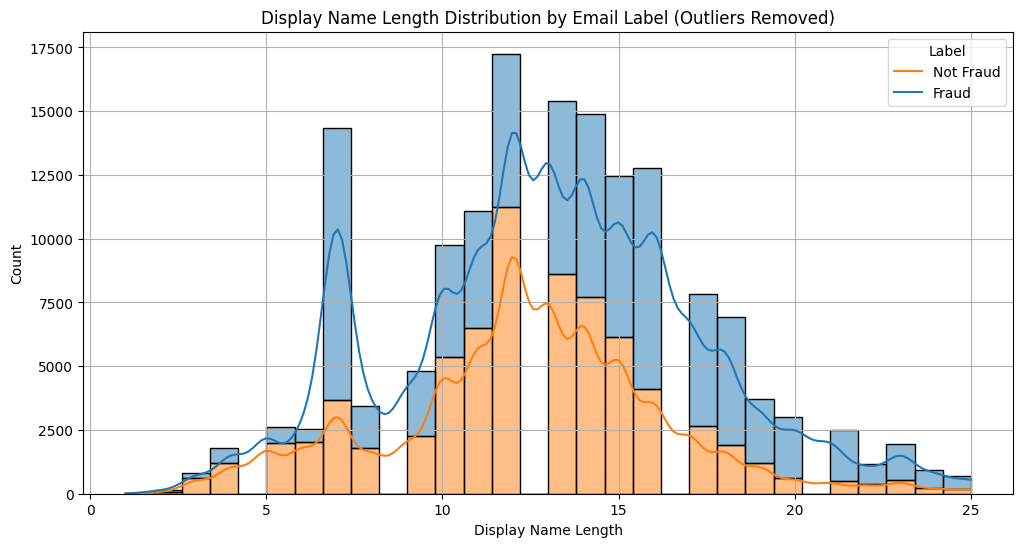

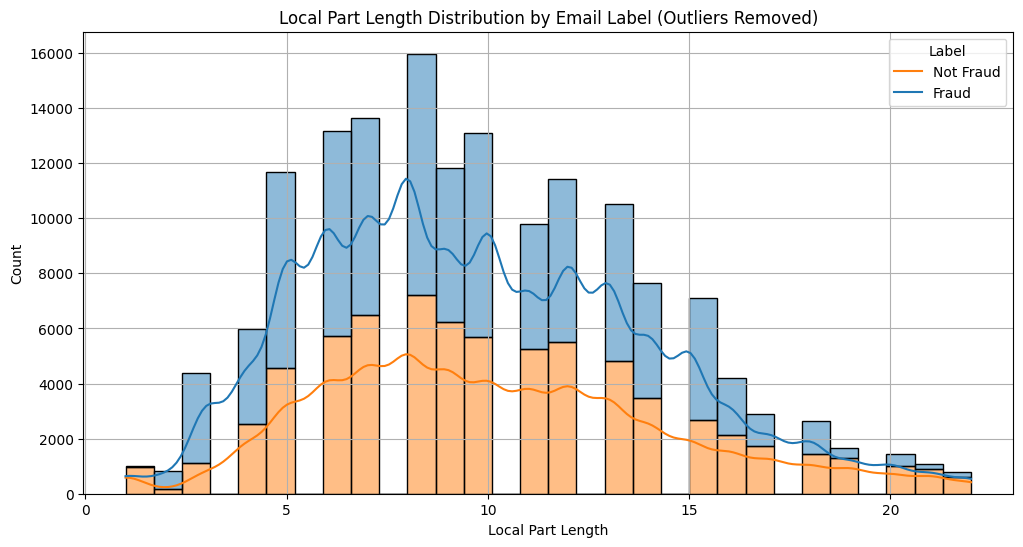


Display Name Length Statistics by Label:
         count       mean      std  min   25%   50%   75%   max
label                                                          
0.0    81129.0  13.571596  4.51870  1.0  10.0  14.0  17.0  25.0
1.0    71568.0  12.349458  3.86261  1.0  10.0  12.0  15.0  25.0

Local Part Length Statistics by Label:
         count       mean       std  min  25%   50%   75%   max
label                                                          
0.0    81129.0   9.440915  3.982348  1.0  6.0   9.0  12.0  22.0
1.0    71568.0  10.202828  4.394151  1.0  7.0  10.0  13.0  22.0

T-Test Results for Display Name Length:
T-Statistic: 56.97313231627245, P-Value: 0.0

T-Test Results for Local Part Length:
T-Statistic: -35.32249249267508, P-Value: 3.807840791003113e-272


/var/folders/sh/vlhhxd9x3434f0ckcn3rcns80000gn/T/ipykernel_3857/2015492674.py:117: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_stat_display, p_value_display = stats.ttest_ind(not_fraud_display, fraud_display, equal_var=False)
/var/folders/sh/vlhhxd9x3434f0ckcn3rcns80000gn/T/ipykernel_3857/2015492674.py:125: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_stat_local, p_value_local = stats.ttest_ind(not_fraud_local, fraud_local, equal_var=False)


In [10]:
# Function to extract the Display Name from email (before "<email>")
def extract_display_name(sender):
    match = re.search(r'(.*)<', sender)
    return match.group(1).strip() if match else 'unknown'

# Function to extract the Local Part from email (before "@")
def extract_local_part(sender):
    local_part = sender.split('@')[0].split('<')[-1].strip()
    return local_part if local_part else 'unknown'


# Extract Display Name and Local Part
df['display_name'] = df['sender'].apply(extract_display_name)
df['local_part'] = df['sender'].apply(extract_local_part)
local_part_counts = df['local_part'].value_counts()
display_name_counts = df['display_name'].value_counts()
print(local_part_counts)
print(display_name_counts)
# Create length features for analysis
df['display_name_length'] = df['display_name'].apply(len)
df['local_part_length'] = df['local_part'].apply(len)

# Get frequency of display names and local parts
display_name_freq = df['display_name'].value_counts()
local_part_freq = df['local_part'].value_counts()

# Calculate phishing rate by display name and local part
display_name_phishing_rate = df.groupby('display_name')['label'].mean()
local_part_phishing_rate = df.groupby('local_part')['label'].mean()

# Merge frequency with phishing rates
display_name_stats = pd.DataFrame({
    'frequency': display_name_freq,
    'phishing_rate': display_name_phishing_rate
}).reset_index().rename(columns={'index': 'display_name'})

local_part_stats = pd.DataFrame({
    'frequency': local_part_freq,
    'phishing_rate': local_part_phishing_rate
}).reset_index().rename(columns={'index': 'local_part'})

# Filter for phishing rate < 0.25 and > 0.75
display_name_safe = display_name_stats[display_name_stats['phishing_rate'] < 0.25].sort_values(by='frequency', ascending=False)
display_name_risky = display_name_stats[display_name_stats['phishing_rate'] > 0.75].sort_values(by='frequency', ascending=False)

local_part_safe = local_part_stats[local_part_stats['phishing_rate'] < 0.25].sort_values(by='frequency', ascending=False)
local_part_risky = local_part_stats[local_part_stats['phishing_rate'] > 0.75].sort_values(by='frequency', ascending=False)

# Display the top display names with phishing rate < 0.25 and > 0.75
print("\nTop Display Names with Phishing Rate < 0.25:")
print(display_name_safe.head(10))
print(display_name_safe.head(10)["display_name"].to_list())

print("\nTop Display Names with Phishing Rate > 0.75:")
print(display_name_risky.head(10))
print(display_name_risky.head(10)["display_name"].to_list())

# Display the top local parts with phishing rate < 0.25 and > 0.75
print("\nTop Local Parts with Phishing Rate < 0.25:")
print(local_part_safe.head(10))
print(local_part_safe.head(10)["local_part"].to_list())

print("\nTop Local Parts with Phishing Rate > 0.75:")
print(local_part_risky.head(10))
print(local_part_risky.head(10)["local_part"].to_list())

# Function to remove outliers using IQR method
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

# Remove outliers from display name length
df = df[df['display_name_length'].isin(remove_outliers_iqr(df['display_name_length']))]

# Remove outliers from local part length
df = df[df['local_part_length'].isin(remove_outliers_iqr(df['local_part_length']))]

# Visualize display name length distribution by label
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='display_name_length', hue='label', multiple='stack', bins=30, kde=True)
plt.title('Display Name Length Distribution by Email Label (Outliers Removed)')
plt.xlabel('Display Name Length')
plt.ylabel('Count')
plt.legend(title='Label', labels=['Not Fraud', 'Fraud'])
plt.grid()
plt.show()

# Visualize local part length distribution by label
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='local_part_length', hue='label', multiple='stack', bins=30, kde=True)
plt.title('Local Part Length Distribution by Email Label (Outliers Removed)')
plt.xlabel('Local Part Length')
plt.ylabel('Count')
plt.legend(title='Label', labels=['Not Fraud', 'Fraud'])
plt.grid()
plt.show()

# Calculate statistics for display name and local part lengths by label
display_name_stats = df.groupby('label')['display_name_length'].describe()
local_part_stats = df.groupby('label')['local_part_length'].describe()

# Display statistics
print("\nDisplay Name Length Statistics by Label:")
print(display_name_stats)
print("\nLocal Part Length Statistics by Label:")
print(local_part_stats)

# Separate the two groups for display name length
not_fraud_display = df[df['label'] == 0]['display_name_length']
fraud_display = df[df['label'] == 1]['display_name_length']

# Perform t-test for display name length
t_stat_display, p_value_display = stats.ttest_ind(not_fraud_display, fraud_display, equal_var=False)
print(f"\nT-Test Results for Display Name Length:\nT-Statistic: {t_stat_display}, P-Value: {p_value_display}")

# Separate the two groups for local part length
not_fraud_local = df[df['label'] == 0]['local_part_length']
fraud_local = df[df['label'] == 1]['local_part_length']

# Perform t-test for local part length
t_stat_local, p_value_local = stats.ttest_ind(not_fraud_local, fraud_local, equal_var=False)
print(f"\nT-Test Results for Local Part Length:\nT-Statistic: {t_stat_local}, P-Value: {p_value_local}")


Although the t-test results indicate a statistically significant difference in the mean lengths of display names and local parts between the two groups, visual inspection of the histograms reveals that the distributions appear quite similar. Therefore, we have decided not to include these features in our analysis as it could bring noise to the models.

### EDA for Subject
These are the features we plan to extract from the Subject:

e.g Never agree to be a loser
1. Presence of Blacklist words (from predefined blacklist words)
2. Presence of Whitelist words (from predefined whitelist words)
3. Whether the Subject is a reply to an email
4. Whether the Subject contains words in PascalCase

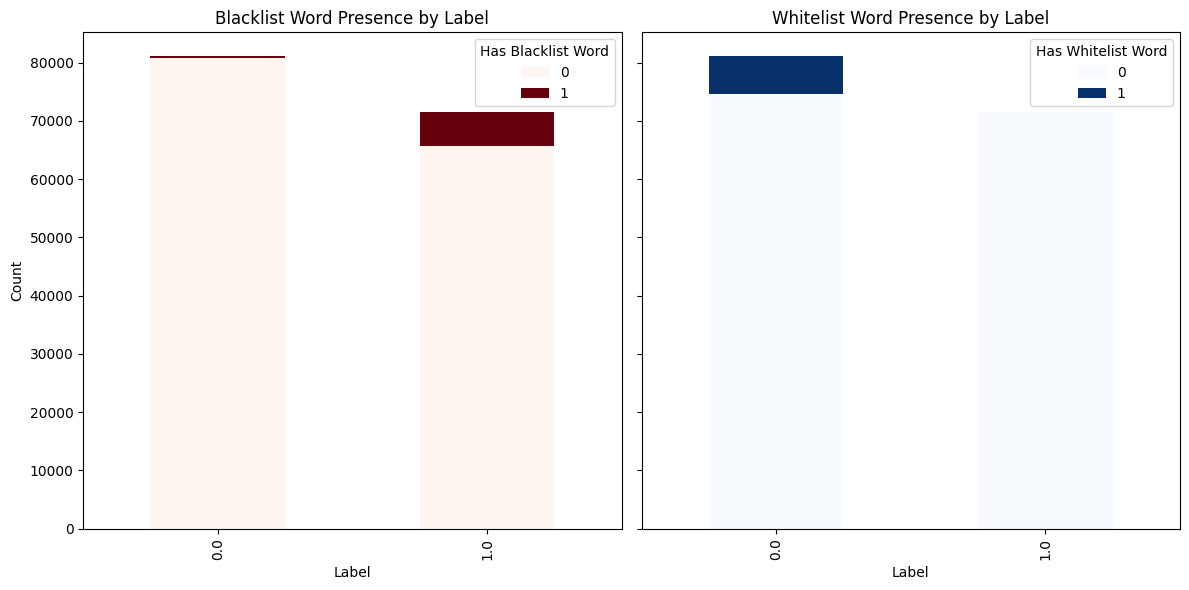

In [11]:
# Define the blacklist and whitelist words
# Indicates presence of blacklisted word in the subject (1 : ‘Yes’, 0 : ‘No’)
# Indicates presence of whitelisted word in the subject (1 : ‘Yes’, 0 : ‘No’)
blacklist_words = [
    'price', 'immediate', 'sex', 'replica', 'watches', 'custom', 
    'money', 'account', 'urgent', 'online', 'secure', 'penis', 
    'cnn.com'
]
whitelist_words = [
    'AccuWeather', 'UAI', 'perl', 'svn', 'commit', 'samba'
]

# Function to check presence of blacklist words and whitelist words
def contains_blacklist_words(subject):
    return any(word in subject for word in blacklist_words)

def contains_whitelist_words(subject):
    return any(word in subject for word in whitelist_words)

# Create a new column indicating presence (1) or absence (0) of blacklist words
df['has_blacklist_word'] = df['subject'].apply(contains_blacklist_words).astype(int)
df['has_whitelist_word'] = df['subject'].apply(contains_whitelist_words).astype(int)

# Calculate counts for each label
blacklist_presence_counts = df.groupby('label')['has_blacklist_word'].value_counts().unstack(fill_value=0)
whitelist_presence_counts = df.groupby('label')['has_whitelist_word'].value_counts().unstack(fill_value=0)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Blacklist bar plot
blacklist_presence_counts.plot(kind="bar", stacked=True, ax=axes[0], colormap="Reds")
axes[0].set_title("Blacklist Word Presence by Label")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Count")
axes[0].legend(title="Has Blacklist Word", loc="upper right")

# Whitelist bar plot
whitelist_presence_counts.plot(kind="bar", stacked=True, ax=axes[1], colormap="Blues")
axes[1].set_title("Whitelist Word Presence by Label")
axes[1].set_xlabel("Label")
axes[1].legend(title="Has Whitelist Word", loc="upper right")

plt.tight_layout()
plt.show()


In [12]:
# Perform the chi-square test
def run_chi_square_test(counts, label):
    chi2_stat, p_val, dof, expected = chi2_contingency(counts)
    print(f"\nChi-square statistic for {label}: {chi2_stat}")
    print(f"P-value for {label}: {p_val}")

# Run the test for both blacklist and whitelist
run_chi_square_test(blacklist_presence_counts.values, "blacklist")
run_chi_square_test(whitelist_presence_counts.values, "whitelist")


Chi-square statistic for blacklist: 5911.9062208544965
P-value for blacklist: 0.0

Chi-square statistic for whitelist: 6000.52026813928
P-value for whitelist: 0.0


From the chi-sqaure test, we reject the null hypothesis that the association between the presence of blacklist/whitelist words and the labels equals zero. Therefore, there is a statistically significant relationship between word presence and the labels.

From the barplots we can observe clear differences in the distribution of blacklist and whitelist word presence across the labels, indicating that the presence of these words is not evenly distributed. Hence, we will include these features for our models.


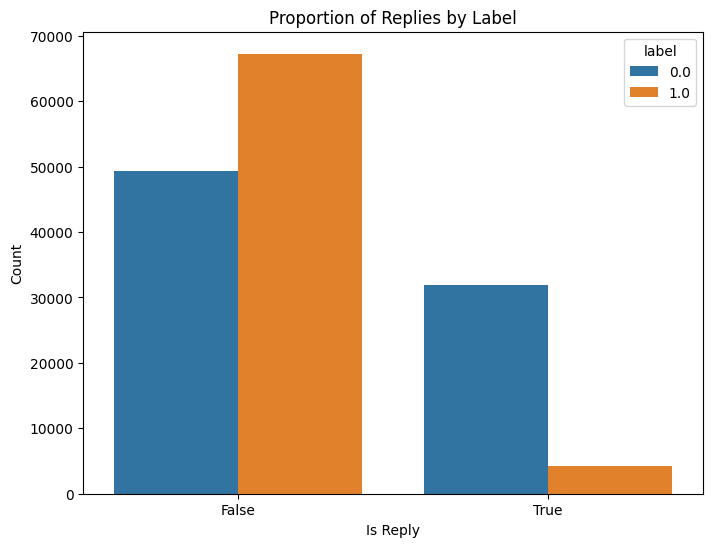

Chi-square statistic: 23232.033194900127
P-value: 0.0


In [13]:
# Feature for whether the subject is a reply to an email
def subj_reply(subject):
    return subject.lower().startswith("re:")

df['is_subject_reply'] = df['subject'].apply(subj_reply)

# Plot for proportion of replies
plt.figure(figsize=(8, 6))
sns.countplot(x='is_subject_reply', data=df, hue='label')
plt.title("Proportion of Replies by Label")
plt.xlabel("Is Reply")
plt.ylabel("Count")
plt.show()

reply_contingency_table = pd.crosstab(df['is_subject_reply'], df['label'])

# Perform the chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(reply_contingency_table)

# Print results
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_val)



As seen from the barplot and the p-value from the chi-square test, the relationship between subject is a reply and the label is statistically significant.
We have decided to include this feature in our analysis


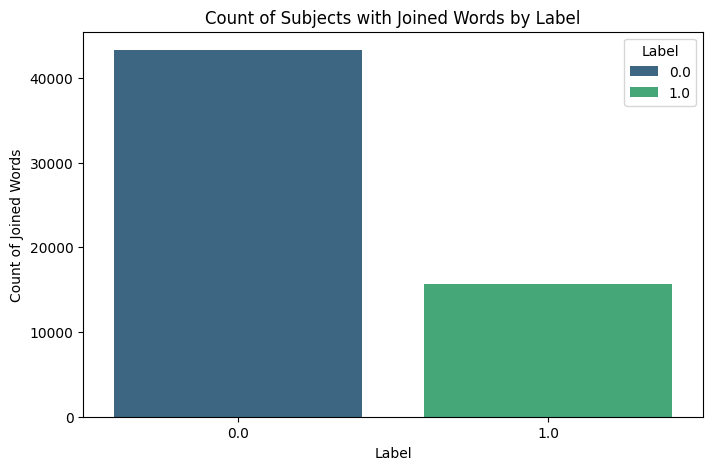

Chi-square statistic: 15834.643580522286
P-value: 0.0


In [14]:
# Function to check for joined words/PascalCase in the subject
def has_joined_words(subject):
    return bool(re.search(r'[a-zA-Z]+[A-Z][a-zA-Z]|[A-Z]{2,}', subject))

# Create a new column indicating presence/absence of PascalCase words
df['has_joined_words'] = df['subject'].apply(has_joined_words)

# Count occurrences of joined words by label
joined_words_count_by_label = df.groupby('label')['has_joined_words'].sum().reset_index()

# Rename columns for clarity
joined_words_count_by_label.columns = ['Label', 'Joined Words Count']

# Plotting the results
plt.figure(figsize=(8, 5))
sns.barplot(data=joined_words_count_by_label, x='Label', y='Joined Words Count', palette='viridis', hue='Label')
plt.title('Count of Subjects with Joined Words by Label')
plt.xlabel('Label')
plt.ylabel('Count of Joined Words')
plt.xticks(rotation=0)  # Keep x-ticks horizontal
plt.show()

# Perform the chi-square test
joined_words_contingency_table = pd.crosstab(df['has_joined_words'], df['label'])
chi2_stat, p_val, dof, expected = chi2_contingency(joined_words_contingency_table)

# Print the results
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_val)

As seen from the barplot and the p-value from the chi-square test, the relationship between the presence of a PascalCase word in the subject and the label is statistically significant.
We have decided to include this feature in our analysis


### EDA for Date

For the Date column, we looked into the percentage of phising cases by month and see if one hot encoding is justified:

e.g Jan
1. One hot encoding for months

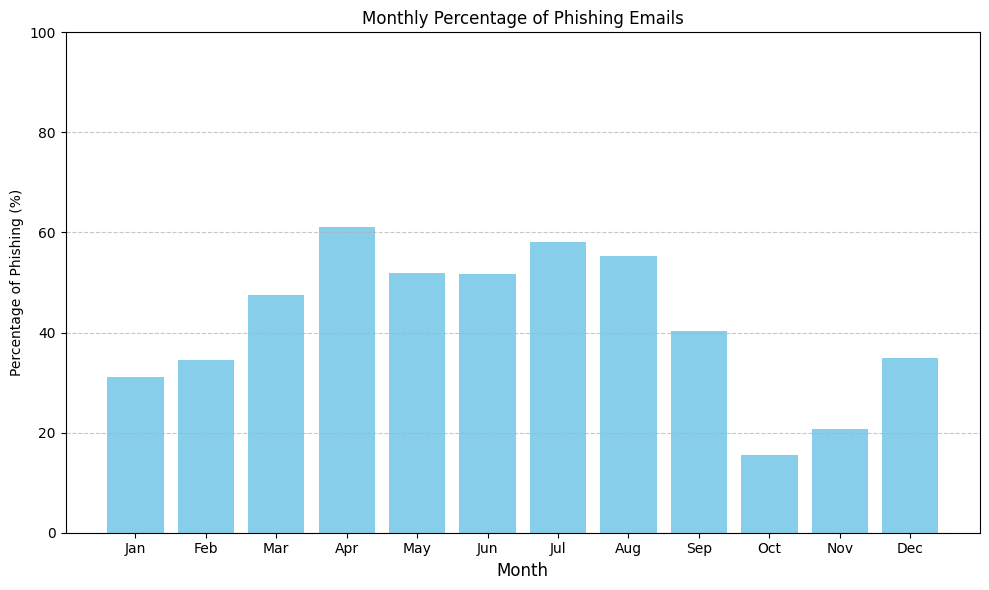

In [15]:
# Calculate the percentage of fraud cases by month
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])
fraud_percentage_by_month = df.groupby(df['date'].dt.month)['label'].mean() * 100

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(fraud_percentage_by_month.index, fraud_percentage_by_month.values, color='skyblue')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Percentage of Phishing (%)')
plt.title('Monthly Percentage of Phishing Emails')
plt.ylim(0, 100)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.show()

From the barplot we can observe that some months (Apr and Jul) have higher percentage of phishing emails than others (Oct and Nov). We decided to include this feature for our models.

### EDA for Body

Looking into the Body column, these are some of the features we plan to extract:

e.g. 'Buck up, your troubles caused by small dimension will soon be over!\nBecome a lover no woman will be able to resist!\nhttp://whitedone.com/\n\n\ncome. Even as Nazi tanks were rolling down the streets, the dreamersphilosopher or a journalist. He was still not sure.I do the same.'

1. URL Classification 
2. Phishing keyword count
3. Exclamation count
4. IP URL count
5. Uppercase word count
6. Special character ratio
7. Average word length
8. Suspicious TLD count
9. Question mark count
10. HTML tags count
11. Word Count

Average URL Length: 57.1639689443198
URL Distribution:
 label           0.0      1.0
Legitimate  69555.0  58446.0
Suspicious   6739.0   6659.0
Phishing     2613.0   3179.0


<Figure size 1000x600 with 0 Axes>

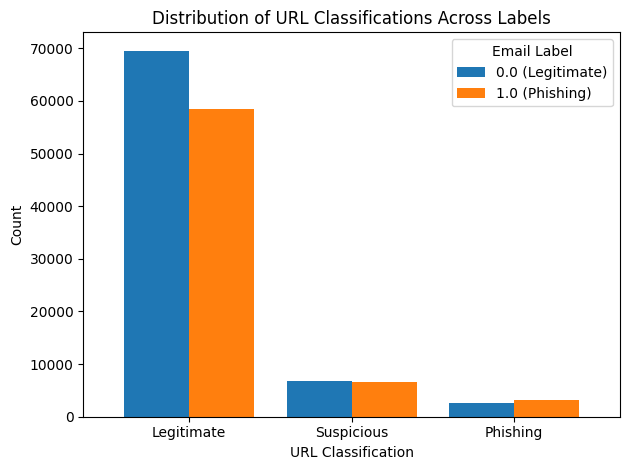

In [16]:
# Define a function to classify URLs
def classify_url(body, avg_length):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    urls = url_pattern.findall(body)

    if not urls:
        return [1.0, 0.0, 0.0]  # No URLs means it's legitimate

    for url in urls:
        url_length = len(url)
        if url_length >= avg_length * 1.5:
            return [0.0, 0.0, 1.0]  # Phishing URL
        elif avg_length <= url_length < avg_length * 1.5:
            return [0.0, 1.0, 0.0]  # Suspicious URL

    return [1.0, 0.0, 0.0]  # Legitimate URL

# Calculate average URL length
def get_url_average_length(df, body_column):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    url_lengths = [len(url) for body in df[body_column] for url in url_pattern.findall(body)]
    return sum(url_lengths) / len(url_lengths) if url_lengths else 0

# Process df
avg_url_length = get_url_average_length(df, 'body')
print(f'Average URL Length: {avg_url_length}')
url_classifications = df['body'].apply(lambda body: classify_url(body, avg_url_length))
url_classifications_df = pd.DataFrame(url_classifications.tolist(), columns=['Legitimate', 'Suspicious', 'Phishing'])

# Concatenate classifications with the original DataFrame
df = pd.concat([df, url_classifications_df], axis=1)

# Count the classifications for each label
url_distribution = df.groupby('label')[['Legitimate', 'Suspicious', 'Phishing']].sum().T

# Print the distribution DataFrame
print("URL Distribution:\n", url_distribution)

# Plotting
plt.figure(figsize=(10, 6))
url_distribution.plot(kind='bar', width=0.8)
plt.title('Distribution of URL Classifications Across Labels')
plt.xlabel('URL Classification')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Email Label', labels=['0.0 (Legitimate)', '1.0 (Phishing)'])
plt.tight_layout()
plt.show()


In [17]:
chi2_stat, p_val, dof, expected = chi2_contingency(url_distribution)
print(f"Chi-square statistic for URL classification: {chi2_stat}")
print(f"P-value: {p_val}")

Chi-square statistic for URL classification: 254.5677168134276
P-value: 5.264082155519244e-56


From the plot, there is a balanced distribution for Legitimate URLs, Suspicious URLs show more legitimate than phishing cases while Phishing URLs show more phishing than legitimate cases. The chi-square test results also show that there is a significant relationship between URL Classification and the label. 

Therefore, we will include this feature for our analysis.

In [18]:
df = pd.read_csv("combined_cleaned_data_updated.csv")
#Predetermined phishing keywords
phishing_keywords = ['urgent', 'free', 'winner', 'offer', 'limited', 'click', 'claim', 'prize']
df['phishing_keyword_count'] = df['body'].apply(lambda x: sum(word in x.lower() for word in phishing_keywords) if pd.notnull(x) else 0)


In [19]:
#Special characters
df['exclamation_count'] = df['body'].apply(lambda x: x.count('!') if pd.notnull(x) else 0)
df['question_mark_count'] = df['body'].apply(lambda x: x.count('?') if pd.notnull(x) else 0)
df['html_tags'] = df['body'].apply(lambda x: 1 if '<' in x and '>' in x else 0)

In [20]:
#Text complexity features
df['word_count'] = df['body'].str.split().apply(len)
df['average_word_length'] = df['body'].apply(lambda x: (sum(len(word) for word in x.split()) / len(x.split())) if pd.notnull(x) and len(x.split()) > 0 else 0)
df['uppercase_word_count'] = df['body'].apply(lambda x: sum(1 for word in x.split() if word.isupper()) if pd.notnull(x) else 0)
special_chars = "!$#@"
df['special_char_ratio'] = df['body'].apply(lambda x: sum(1 for char in x if char in special_chars) / len(x) if pd.notnull(x) and len(x) > 0 else 0)


In [21]:
#IP address and suspicious TLD features
ip_pattern = r'\b\d{1,3}(?:\.\d{1,3}){3}\b'
df['ip_url_count'] = df['body'].apply(lambda x: len(re.findall(ip_pattern, x)) if pd.notnull(x) else 0)
suspicious_tlds = ['.xyz', '.biz', '.info']
df['suspicious_tld_count'] = df['body'].apply(lambda x: sum(tld in x.lower() for tld in suspicious_tlds) if pd.notnull(x) else 0)


/var/folders/sh/vlhhxd9x3434f0ckcn3rcns80000gn/T/ipykernel_3857/725090998.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_counts = df.groupby([f'{feature}_quantile', 'label']).size().reset_index(name='count')


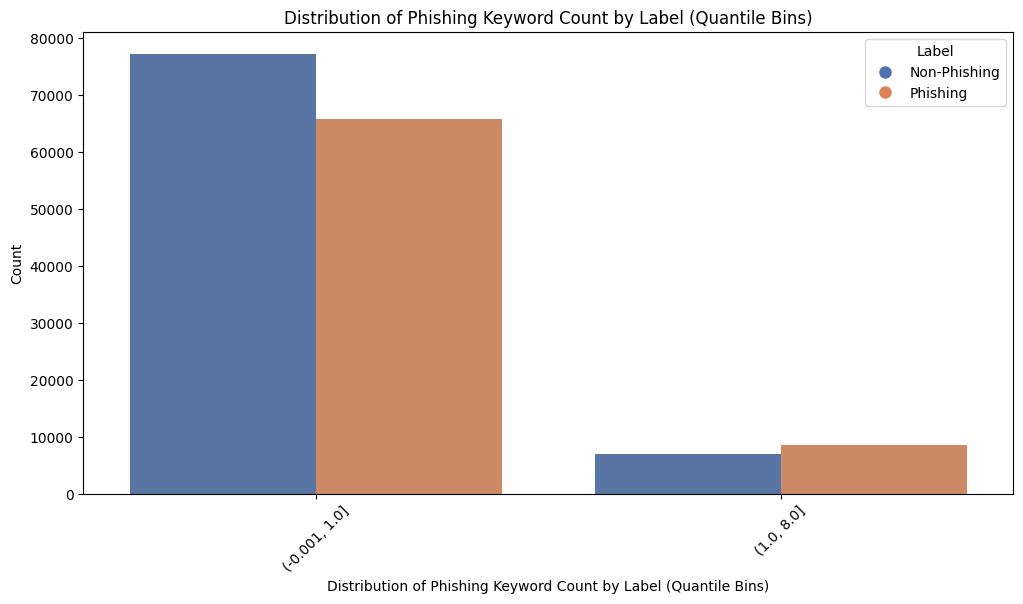

/var/folders/sh/vlhhxd9x3434f0ckcn3rcns80000gn/T/ipykernel_3857/725090998.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_counts = df.groupby([f'{feature}_quantile', 'label']).size().reset_index(name='count')


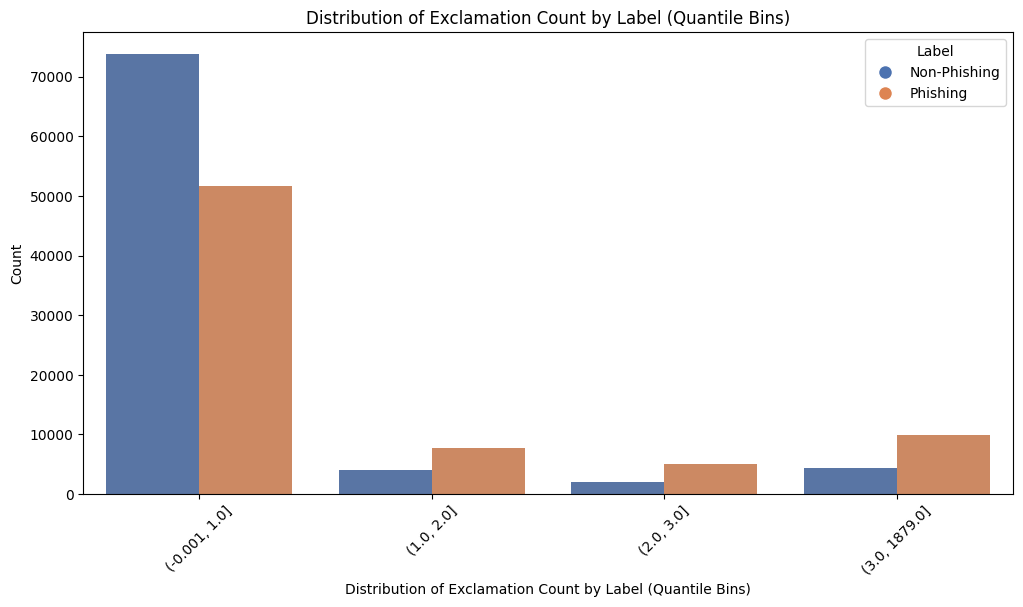

/var/folders/sh/vlhhxd9x3434f0ckcn3rcns80000gn/T/ipykernel_3857/725090998.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_counts = df.groupby([f'{feature}_quantile', 'label']).size().reset_index(name='count')


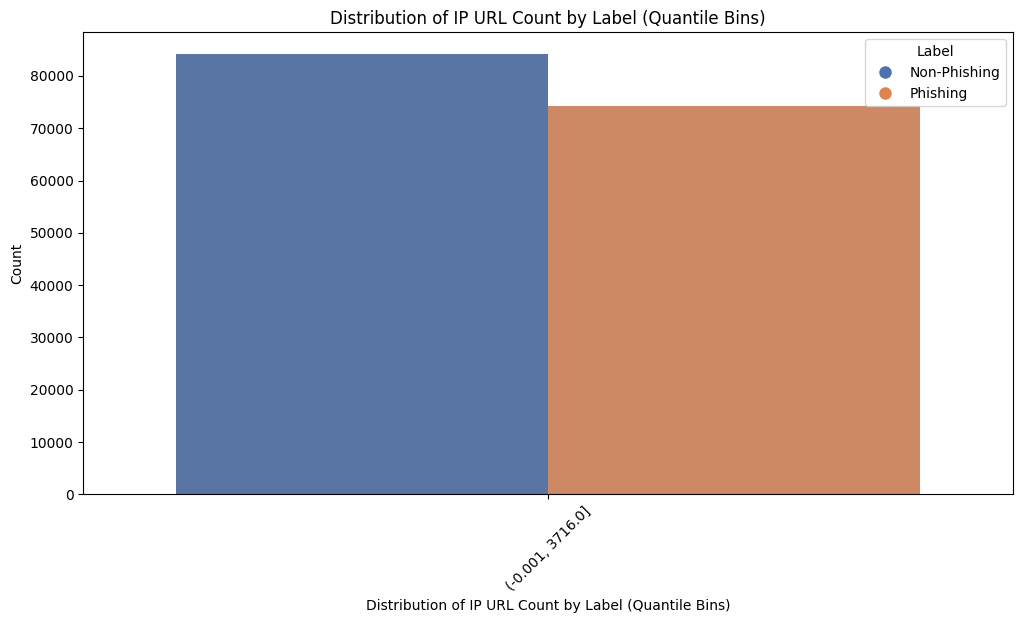

/var/folders/sh/vlhhxd9x3434f0ckcn3rcns80000gn/T/ipykernel_3857/725090998.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_counts = df.groupby([f'{feature}_quantile', 'label']).size().reset_index(name='count')


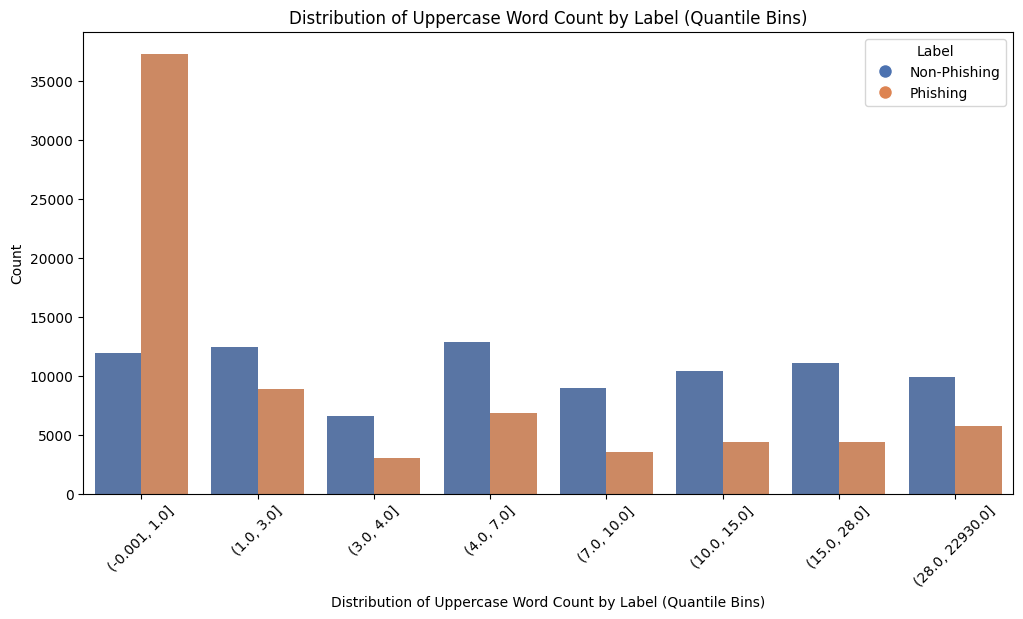

/var/folders/sh/vlhhxd9x3434f0ckcn3rcns80000gn/T/ipykernel_3857/725090998.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_counts = df.groupby([f'{feature}_quantile', 'label']).size().reset_index(name='count')


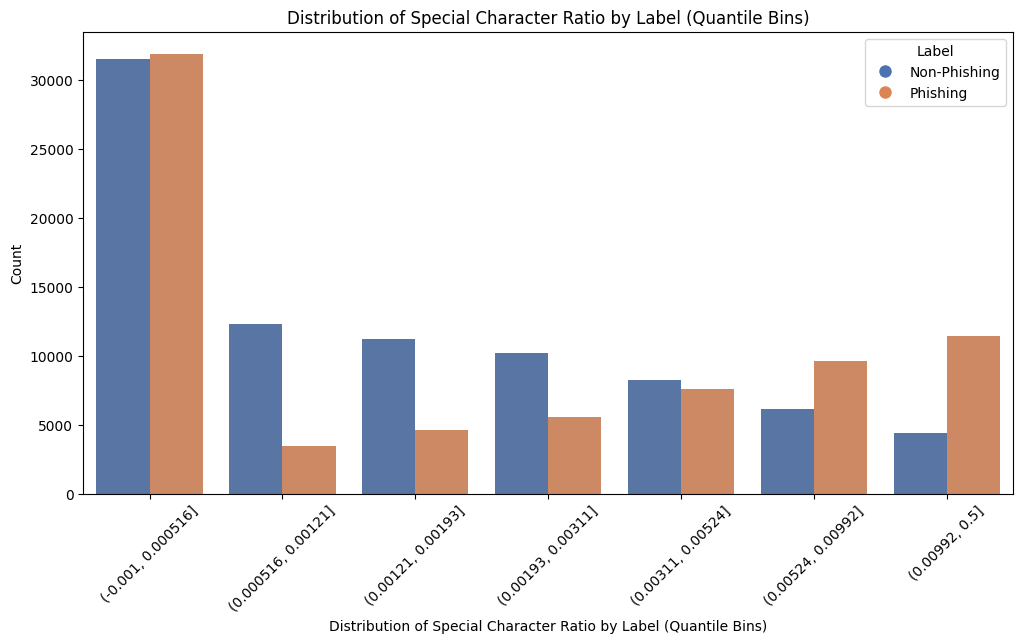

/var/folders/sh/vlhhxd9x3434f0ckcn3rcns80000gn/T/ipykernel_3857/725090998.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_counts = df.groupby([f'{feature}_quantile', 'label']).size().reset_index(name='count')


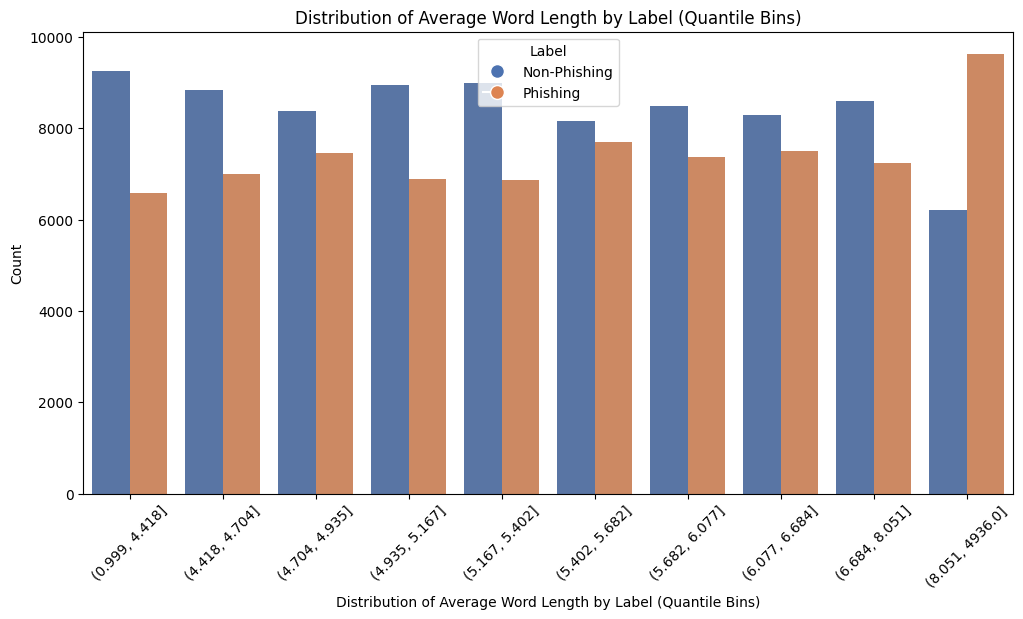

/var/folders/sh/vlhhxd9x3434f0ckcn3rcns80000gn/T/ipykernel_3857/725090998.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_counts = df.groupby([f'{feature}_quantile', 'label']).size().reset_index(name='count')


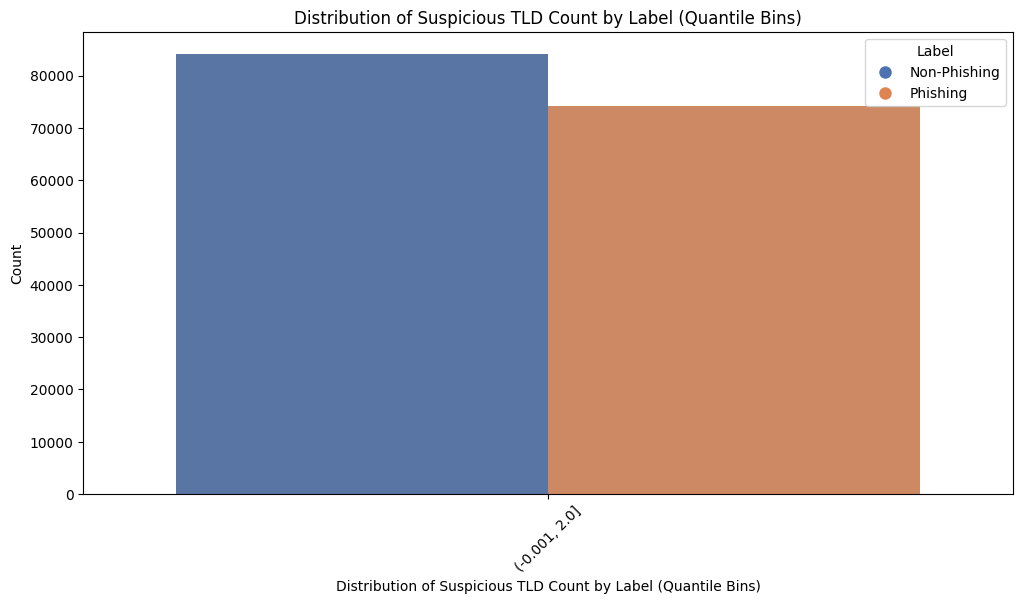

/var/folders/sh/vlhhxd9x3434f0ckcn3rcns80000gn/T/ipykernel_3857/725090998.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_counts = df.groupby([f'{feature}_quantile', 'label']).size().reset_index(name='count')


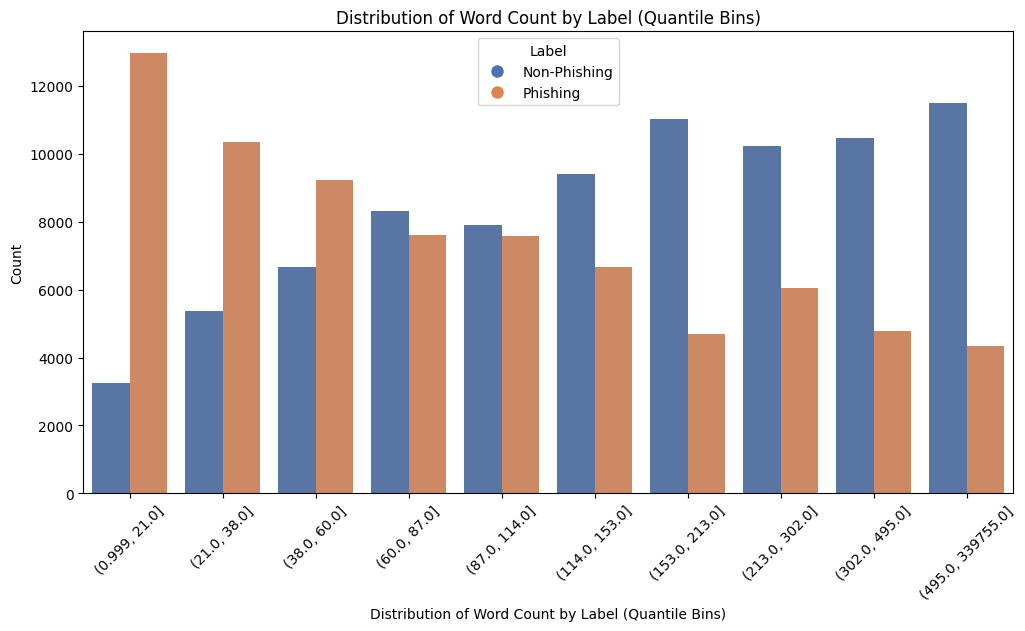

/var/folders/sh/vlhhxd9x3434f0ckcn3rcns80000gn/T/ipykernel_3857/725090998.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_counts = df.groupby([f'{feature}_quantile', 'label']).size().reset_index(name='count')


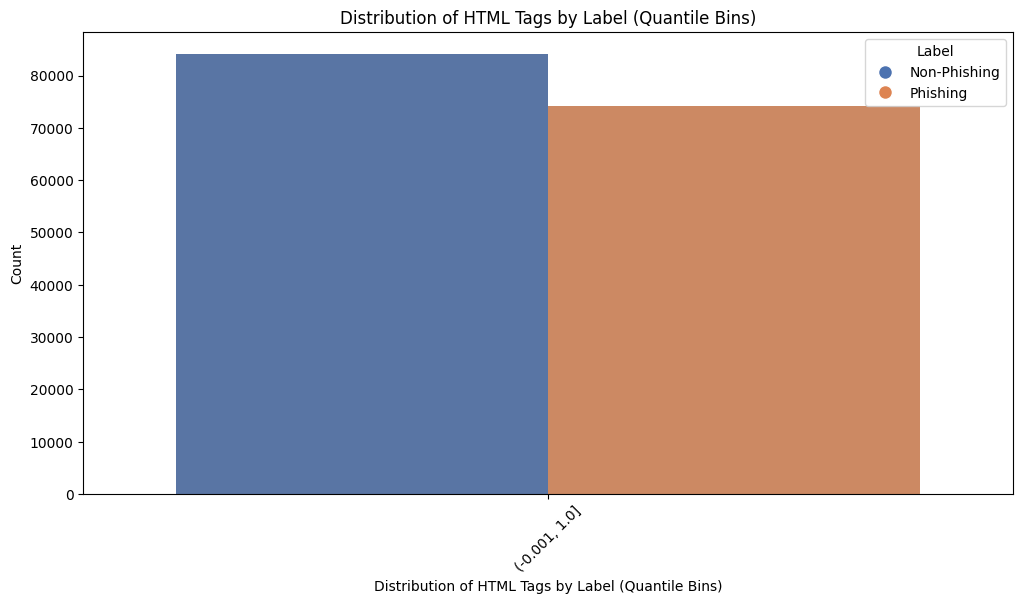

/var/folders/sh/vlhhxd9x3434f0ckcn3rcns80000gn/T/ipykernel_3857/725090998.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  feature_counts = df.groupby([f'{feature}_quantile', 'label']).size().reset_index(name='count')


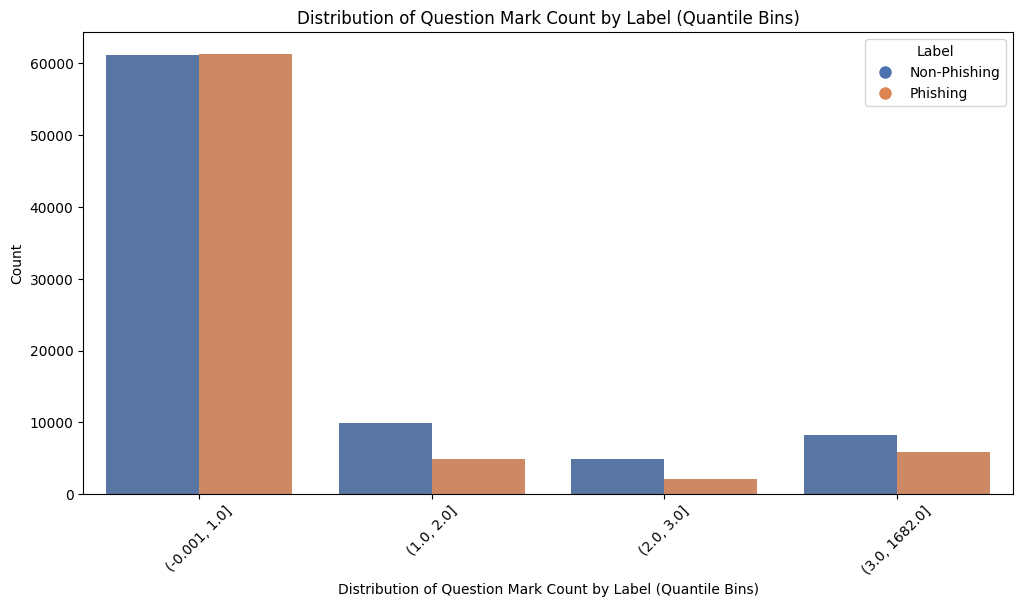

In [22]:
# Define colors for Non-Phishing and Phishing
colors = ["#4C72B0", "#DD8452"]  # Blue for Non-Phishing, Orange for Phishing

# Function to plot each feature with quantile binning and custom legend colors
def plot_feature_quantile_binned(feature, title):
    # Create quantile bins
    df[f'{feature}_quantile'] = pd.qcut(df[feature], q=10, duplicates='drop')
    feature_counts = df.groupby([f'{feature}_quantile', 'label']).size().reset_index(name='count')
    
    # Plot with custom colors
    plt.figure(figsize=(12, 6))
    sns.barplot(x=f'{feature}_quantile', y='count', hue='label', data=feature_counts, palette=colors)
    plt.xticks(rotation=45)
    plt.title(f"{title} (Quantile Bins)")
    plt.xlabel(f"{title} (Quantile Bins)")
    plt.ylabel("Count")
    
    # Custom legend with matching colors
    plt.legend(title="Label", labels=["Non-Phishing", "Phishing"], handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[0], markersize=10, label='Non-Phishing'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[1], markersize=10, label='Phishing')
    ])
    
    plt.show()

# Call the function for each feature
plot_feature_quantile_binned('phishing_keyword_count', "Distribution of Phishing Keyword Count by Label")
plot_feature_quantile_binned('exclamation_count', "Distribution of Exclamation Count by Label")
plot_feature_quantile_binned('ip_url_count', "Distribution of IP URL Count by Label")
plot_feature_quantile_binned('uppercase_word_count', "Distribution of Uppercase Word Count by Label")
plot_feature_quantile_binned('special_char_ratio', "Distribution of Special Character Ratio by Label")
plot_feature_quantile_binned('average_word_length', "Distribution of Average Word Length by Label")
plot_feature_quantile_binned('suspicious_tld_count', "Distribution of Suspicious TLD Count by Label")
plot_feature_quantile_binned('word_count', "Distribution of Word Count by Label")
plot_feature_quantile_binned('html_tags', "Distribution of HTML Tags by Label")
plot_feature_quantile_binned('question_mark_count', "Distribution of Question Mark Count by Label")


In [24]:
# Ensure numeric conversion for all relevant features
numeric_columns = [
    'ip_url_count', 
    'suspicious_tld_count', 
    'word_count', 
    'average_word_length', 
    'uppercase_word_count', 
    'special_char_ratio', 
    'exclamation_count', 
    'phishing_keyword_count',
    'html_tags',
    'question_mark_count'
]

# Convert any non-numeric columns to numeric, coercing errors
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Prepare a DataFrame with only the numeric feature columns and the label
features_df = df[numeric_columns + ['label']]

# Correlation analysis using only the selected features
correlation_matrix = features_df.corr()
phishing_correlations = correlation_matrix['label'].sort_values(ascending=False)
print("Feature Correlations with Phishing Label:\n", phishing_correlations)

# T-tests for each feature
for feature in numeric_columns:
    not_phishing = df[df['label'] == 0][feature]
    phishing = df[df['label'] == 1][feature]
    t_stat, p_value = stats.ttest_ind(not_phishing, phishing, equal_var=False)
    print(f"T-Test for {feature} - T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4e}")


Feature Correlations with Phishing Label:
 label                     1.000000
special_char_ratio        0.137809
suspicious_tld_count      0.114904
phishing_keyword_count    0.075561
average_word_length       0.026901
exclamation_count         0.022643
ip_url_count             -0.008777
uppercase_word_count     -0.033282
question_mark_count      -0.035873
word_count               -0.061806
html_tags                -0.093402
Name: label, dtype: float64
T-Test for ip_url_count - T-Statistic: 3.7187, P-Value: 2.0035e-04
T-Test for suspicious_tld_count - T-Statistic: -44.0161, P-Value: 0.0000e+00
T-Test for word_count - T-Statistic: 26.1854, P-Value: 1.4994e-150
T-Test for average_word_length - T-Statistic: -10.0601, P-Value: 8.5851e-24
T-Test for uppercase_word_count - T-Statistic: 14.0140, P-Value: 1.4173e-44
T-Test for special_char_ratio - T-Statistic: -54.6234, P-Value: 0.0000e+00
T-Test for exclamation_count - T-Statistic: -9.5254, P-Value: 1.6813e-21
T-Test for phishing_keyword_count

/var/folders/sh/vlhhxd9x3434f0ckcn3rcns80000gn/T/ipykernel_3857/350316369.py:31: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  t_stat, p_value = stats.ttest_ind(not_phishing, phishing, equal_var=False)


<h5>Phishing Keyword Count:</h5>

The bar plot shows that phishing emails tend to have higher phishing keyword counts, while non-phishing emails dominate the lower counts. The T-test (T-statistic: -30.07, P-value: 4.38e-198) confirms a significant difference in phishing keyword counts between the two labels. With a positive correlation (0.0756) to the phishing label, this feature is a valuable signal for detecting phishing emails and will be included in the model.

<h5>Exclamation Count</h5>

The plot shows that phishing emails often have higher exclamation counts, especially in upper quantiles (3.0–1879.0), while non-phishing emails dominate lower counts (0.001–1.0). The T-test (T-statistic: -9.53, P-value: 1.6813e-21) confirms a significant difference, making exclamation count a useful feature for phishing detection despite its weak correlation (0.0226).

<h5>IP URL Count</h5>

The IP URL count feature shows a similar distribution for phishing and non-phishing emails, with both dominating the lower quantile (0.001–3716.0). The T-test results (T-statistic: 3.72, P-value: 2.00e-04) confirm a statistically significant difference between the two groups, even though the correlation with the phishing label is weak (-0.0088).

<h5>Uppercase word Count</h5>

For uppercase word count, non-phishing emails dominate in higher quantiles, while phishing emails are concentrated in the lowest quantile (0.001–1.0). The T-test (T-statistic: 14.01, P-value: 1.42e-44) highlights a significant difference between the groups. 

<h5>Special Character Ratio</h5>

The special character ratio shows that phishing emails dominate the higher quantiles, indicating a frequent use of special characters in phishing emails. This is supported by a moderate positive correlation with the phishing label (0.1378) and strong statistical significance (T-statistic: -54.62, P-value: 0). 

<h5>Average Word Length</h5>

The average word length feature demonstrates that non-phishing emails tend to have slightly higher average word lengths across most quantiles. The T-test results (T-statistic: -10.06, P-value: 8.59e-24) confirm a significant difference, though the correlation with the phishing label is weak (0.0269)

<h5>Suspicious TLD Count</h5>

For suspicious TLD count, phishing emails dominate the single quantile, reflecting the feature's focus on identifying URLs with suspicious domains. The T-test results (T-statistic: -44.02, P-value: 0) and a moderate correlation with the phishing label (0.1149) shows that it provides value in phishing detection


<h5>Word Count</h5>

For Word count, phishing emails dominate the lower quantiles, while non-phishing emails dominate the upper quantiles. The T-test results (T-statistic: 26.19, P-value: 1.4994e-150) provides value in phishing detection even though there is a weak correlation with the phishing label (-0.061806).

<h5>HTML Tags</h5>

For HTML Tags, phishing emails dominate the single quantile, reflecting the feature's focus on finding html tags. The T-test results (T-statistic: 38.07, P-value: 0) shows that it provides value in phishing detection even though it has a weak correlation with the phishing label (-0.093402) 


<h5>Question Mark Count</h5>

For Question mark count, non-phishing emails dominate the upper quantiles. The T-test results (T-statistic: 15.0589, P-value: 3.4350e-51) shows that it provides value in phishing detection even though it has a weak correlation with the phishing label (-0.035873) 